# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Appendix - References](#References)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [74]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [75]:
## Method 1 - Load from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
## Enter access code in dialog

In [76]:
## Method 1 - Google colab
#path="/content/drive/My Drive/data/ab_data.csv"
#df = pd.read_csv(path)

## Method 2 - Local
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [77]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [78]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [79]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [80]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [81]:
treatment = df.query("group=='treatment'")
# treatment matches with old page
old_treatment = treatment.query("landing_page=='old_page'")

In [82]:
control = df.query("group=='control'")
# control matches with new page
new_control = control.query("landing_page=='new_page'")

In [83]:
old_treatment.group.count(), new_control.group.count()

(1965, 1928)

In [84]:
nonmatch = old_treatment.group.count() + new_control.group.count()
nonmatch

3893

f. Do any of the rows have missing values?

In [85]:
df.isnull().count() < df.shape[0]

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [86]:
df1 = df.drop(old_treatment.index)

In [87]:
df1.size

1462565

In [88]:
df2 = df1.drop(new_control.index)

In [89]:
df2.shape

(290585, 5)

In [90]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [91]:
# Double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [92]:
# Quick overview of entire dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [93]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

*There appears to be a double up in timestamp*

b. There is one **user_id** repeated in **df2**.  What is it?

In [94]:
# create mask to find duplicated, returning true/false results
mask = df2['user_id'].duplicated()

In [95]:
# Apply mask to only return true
df2[mask]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [96]:
dup_index = df2[mask].index[0]
dup_index

2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [97]:
df2.shape

(290585, 5)

In [98]:
df2.drop(dup_index, inplace=True)

In [99]:
# sanity check to confirm
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [100]:
# Quick review of data
df2.head(3) 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [101]:
# the probability of converting is:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [102]:
control_df = df2[df2.group == 'control']
control_df.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [103]:
treatment_df = df2[df2.group == 'treatment']
treatment_df.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [104]:
newpage_df = df2[df2.landing_page == 'new_page']
newpage_df.shape[0]

145310

In [105]:
round(newpage_df.shape[0]/df2.shape[0], 4)

0.5001

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer: No, deriving information from the populations proportions is inadequate to reach a conclusion as it is limited to a select few with possible outliers, more bootstrap sampling and normalising is required to provide a definite and practical solution.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 <= 0, where 𝑝𝑛𝑒𝑤 is not converted being true due to the new page, i.e. old page is better.**

**H1: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 > 0, where 𝑝𝑛𝑒𝑤 is the probability of those converted due to the new page.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [106]:
# assume they are equal to the converted rate in ab_data.csv, !regardless of page landed!
# use df2 as it is the cleaned dataset
round(df2.converted.mean(),6)

0.119597

In [107]:
# sample size
df2.shape[0]

290584

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [108]:
# assume they are equal to the converted rate in ab_data.csv regardless of the page
#pcov = pnew = pold
p_cov = df2.converted.mean()
round((p_cov),6)

0.119597

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [109]:
# As above in a.
round((p_cov),6)

0.119597

c. What is $n_{new}$, the number of individuals in the treatment group?

In [110]:
# with duplicates removed, no need to utilise nunique()
num_new = df2.query("group == 'treatment'")
n_new = num_new.user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [111]:
num_old = df2.query("group == 'control'")
n_old = num_old.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [112]:
# pd.sample does not simulate with probability, from prior lesson need to use np.random.choice to achieve this. Can also use random.binomial as we are simulating 0,1 i.e. converted or not
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_cov, (1- p_cov)], replace=True)

In [113]:
# sample of new, type conversion below
p_new = np.array(new_page_converted)
round(p_new.mean(),6)

0.119159

In [114]:
p_new.shape[0]

145310

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [115]:
old_page_converted = np.random.choice([1,0], size=n_old, p=[p_cov, (1- p_cov)], replace=True)

In [116]:
# sample of old
p_old = np.array(old_page_converted)
round(p_old.mean(),6)

0.120056

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [117]:
p_diff = p_new.mean() - p_old.mean()
p_diff

-0.0008968550835981026

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [118]:
# bootstrap to simulate sampling distrubtion for the difference in proportions
# create 10,000 pnew & pold i.e. 10000 of 'each'
p_diffs = []
samples = 10000

# for sample in range(samples): - Method 1, incorrect use of numpy - per QA
for sample in range(samples):
    p_new = np.random.choice([1,0], size=samples, p=[p_cov, (1- p_cov)], replace=True)
    p_old = np.random.choice([1,0], size=samples, p=[p_cov, (1- p_cov)], replace=True)
    diff = p_new - p_old
    p_diffs.append(diff.mean())

In [119]:
# type conversion into an np array
p_diffs = np.array(p_diffs)
p_diffs

array([-0.0048, -0.0009, -0.0032, ...,  0.0029, -0.0049,  0.0022])

In [120]:
p_diffs.mean()

-4.5800000000000016e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

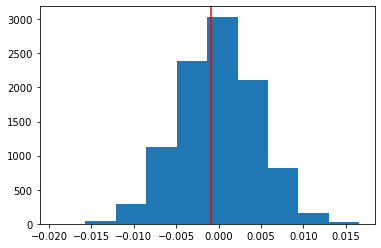

In [121]:
plt.hist(p_diffs)
plt.axvline(x = p_diff, color='r');

**Answer: Here the plot is as expected, as we see a normal distribution curve. Our observed probability is within the curve, due to the law of large numbers allowing the observed parameter to be closer to the average population mean.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [122]:
# the number of p_diffs that exceed (g) are simply the comparison of the array against the observation, then taking the mean of all the comparisons.
pval = (p_diffs > p_diff).mean()
pval

0.5734

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer: The p-value is the observed difference in proportions based on the null hypothesis we set earlier in 1). We have calculated the p-value of this sampled distribution, that has been bootstrapped based on the law of large numbers to allow the sampled mean to be close to the populations mean.**

**In part J, the calculation only accounts for the portion that exceed the observation i.e. one side of the test.**

**All the steps taken to get to (J) are the methods required to achieve this p-value.**

**On the histogram above, the red in the middle is where the observed/actual statistic falls in this normal distribution.
As there is a 5% type error being accounted for, we can say there is 95% certainty the observed mean is from the null.**
 **Where `α` is type I error of 5%**
 
`pval ≤ α ⇒ Reject H0`

`pval > α ⇒ Fail to Reject H0`

**In conclusion, the null hypothesis is likely to be true and we should reject the alternative.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [123]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [124]:
# number of ppl using the old page
oldpage_df = df2[df2.landing_page == 'old_page']
oldpage_df.shape[0]

## newpage_df is from above.
# newpage_df = df2[df2.landing_page == 'new_page']
# newpage_df.shape[0]

145274

In [125]:
#load libraries for the ztest
import statsmodels.api as sm
import pandas.util.testing as tm

# old & new page that are converted
convert_old = oldpage_df.query('converted==1').shape[0]
convert_new = newpage_df.query('converted==1').shape[0]

# number of old and new pages regardless of conversion
n_old = oldpage_df.shape[0]
n_new = newpage_df.shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [126]:
count = [convert_old, convert_new]
nobs = [n_old, n_new]
# value is 0, as p_new = p_old = 0 assuming they are equal under the null i.e. p_new-p_old = 0
# sequencing old first before new, results in alternative being set to smaller i.e. old < new
z_test , p_value = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
round(z_test, 4) , round(p_value, 4)

(1.3109, 0.9051)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer: Z-score is a metric used to determine how far the interpreted value is from the middle of the distribution. A lower z-score indicates how close the result is to mean of the sampled population. This means, that with a positive z_test, it is approximately 'z_test' values away from the middle of the distribution.**

**The p-values obtained in m) is the result from a one-tailed test as described by stats model documentation using the same number of individuals on the new and old page. The p-value obtained in m) differs in value to j), however the concept remains the same.**

**To reiterate, the p-value of m) is greater than the alpha, i.e. type I error of 5% thus the results are statistically significant and in favour of the null hypothesis whereby the probability of individuals receiving the new page is just as likely they will receive the old page. Practically this means that there is no benefit in implementing a new page as the old page is just an successful.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**This is a categorical metric so the regression we would use is Logistic regression to compare whether converted is successful or not.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [127]:
# add intercept
df2['intercept'] = 1

# create two new columns, calling a single column does not work
df2[['ab_page','drop_page']] = pd.get_dummies(df2['landing_page'])

# drop the baseline
df2 = df2.drop('drop_page', axis = 1)

# review
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [128]:
# dependent variable is converted, as it is what we are trying to predict
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [129]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        22:23:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [130]:
np.exp(-1.9888), np.exp(-0.0150)

(0.13685955841614492, 0.9851119396030626)

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer: The hypothesis in Part II is Pold <= Pold, the alternative being that they don't equal to each other Pnew > Pold. The statistical results yield a p-value that is compared against the alpha, that determines which hypothesis is statistically significant.**

**The null and alternative hypothesis in the logistic regression, reveals a p-value of 0.19 with a negative z, which Part II did not achieve. The negative negative z indicates that the regression model was that of a two-tailed where both the positive and negative portions of the normal distribution are considered. According to Lake Tahoe, converting from a two tailed value is a matter of deducting by 1 and halving to achieve the equipment one tailed test, provided the resultant is less than 0.5.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer: 
Adding additional independent variables to the model adds an increased level of complexity to the interpretation of the dependent i.e. those who are converted.**


**However in doing so, it allows for better prediction of the results and an overview of each variables contribution to the dependents output, provided all other independents remain constant.**


**The major consideration when adding additional variables to the model is dependent upon the context of the test and what is trying to be achieved by building a model. Such as finding the correct independents that are highly relevant to the outcome context of the test.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [131]:
# read country csv
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [132]:
# review how many rows prior to merge
country_df.info(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   intercept     290584 non-null  int64 
 6   ab_page       290584 non-null  uint8 
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


(None, None)

In [133]:
# backup original
df3 = df2
# left join df2 on country_df based on all of the left df and only those matching in the country_df based on user_id
df3 = df3.merge(country_df, how='left', left_on='user_id', right_on='user_id', suffixes=('_df2','_country'))
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [134]:
# review number of unique countries
df3.country.nunique()

3

In [135]:
# reveal what they are, and the current distribution against converted (0,1) and ab_page(0,1)
df3.groupby('country').sum()

,user_id,converted,intercept,ab_page
country,,,,
CA,11434495284,1672,14499,7301.0
UK,57079935417,8739,72466,36106.0
US,160467178251,24342,203619,101903.0


In [136]:
# create two new columns, calling a single column does not work
df3[['CA','UK','drop_US']] = pd.get_dummies(df3['country'])

# drop the baseline
df3 = df3.drop('drop_US', axis = 1)

In [137]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [138]:
# multiply ab_page by country to see if effect i.e. when both are 1
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']

In [139]:
# dependent variable is converted, as it is what we are trying to predict
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'CA_ab_page', 'UK_ab_page']])
results2 = logit_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [140]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 21 Oct 2020   Pseudo R-squ.:               2.364e-05
Time:                        22:23:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_ab_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_ab_page     0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

In [145]:
# intercept, CA_ab_page, UK_ab_page
np.exp(-1.9963), np.exp(-0.0752), np.exp(0.0149)

(0.13583695129818255, 0.92755795618492, 1.0150115583846535)

**Answer: Introducing countries into the regression, creates a multi logistic regression model, with US as the baseline country reveals Canada and the UK were 0.93 and 1.01 times respectively as successful in converting using the new page.
The impact of adding the three countries to the model reveals there was minimal effect overall.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [142]:
# dependent variable is converted, as it is what we are trying to predict
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
results3 = logit_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [143]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        22:23:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [144]:
# intercept, ab_page, CA, UK
np.exp(-1.9893), np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.13679114574153073,
 0.9852104557227469,
 0.9600211149716509,
 1.0099491671175422)

**Answer: The regression model based on the independent variable, ab_page is highly significant to the dependents response. Exponentiating the coefficient, reveals that for someone to convert using the new page, there is an improvement of 0.98 times over the old page, which is not practical due to the improvement being minimal.**

**In conclusion, it is not practically viable to launch a new page to increase conversion rate as the old page is statistically proven to be sufficient due to the null hypothesis being true.**
**The trial of the new page across 3 various countries proved to have minimal impact across two of them, with the third indicated to have a negative trend based assuming other variables to be constant.**

<a id='References'></a>
### Appendix - References:

*   http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm
*   https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
*   https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/
*   https://classroom.udacity.com/nanodegrees/nd002/parts/bb0cbeb6-d3f8-4bae-9dc3-4abba3823e54/modules/70ab0502-76fb-425f-880e-e2c73cdbe753/lessons/b7ae43e6-204a-4816-a177-6c75115cae5f/concepts/9699889c-81cc-4f6e-9eff-ae19dec29b95
*   https://classroom.udacity.com/nanodegrees/nd002/parts/bb0cbeb6-d3f8-4bae-9dc3-4abba3823e54/modules/70ab0502-76fb-425f-880e-e2c73cdbe753/lessons/b7ae43e6-204a-4816-a177-6c75115cae5f/concepts/28777848-e025-4ffe-aea6-9c08d814512a
*   http://www.biostathandbook.com/multipleregression.html
*   http://www.ltcconline.net/greenl/courses/201/hyptest/HypTestHints.htm